In [1]:
# Reference: https://www.degeneratestate.org/posts/2018/Mar/24/causal-inference-with-python-part-1-potential-outcomes/
# for personal study purposes only

In [10]:
from __future__ import division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datagenerators as dg
from causalinference import CausalModel

In [4]:
df0 = dg.generate_dataset_0()
df0.head()

,x,y
0,1,0
1,1,0
2,0,1
3,1,0
4,0,0


In [7]:
def estimate_uplift(ds):
    base = ds[ds.x==0]
    variant = ds[ds.x==1]

    delta = variant.y.mean() - base.y.mean()
    delta_err = 1.96 * np.sqrt(
        variant.y.var() / variant.shape[0] + base.y.var() / base.shape[0]
    )
    return {
        'estimated_effect': delta,
        'standard_error': delta_err,
    }


In [ ]:
estimate_uplift(df0)

In [12]:
from scipy.stats import chi2_contingency

temp = (
    df0
    .assign(placeholder=1)
    .pivot_table(index='x', columns='y', values='placeholder', aggfunc='sum')
)

display(temp)


_, p, _, _ = chi2_contingency(temp, lambda_='log-likelihood')

print(p)


y,0,1
x,,
0,124,123
1,147,106


0.09224468128112676


In [13]:
df0_with_confounder = dg.generate_dataset_0(show_z=True)
df0_with_confounder.head()

,x,y,z
0,1,0,0
1,1,0,0
2,0,1,1
3,0,0,0
4,1,1,1


In [15]:
estimate_uplift(df0_with_confounder.loc[lambda df: df.z==0]), estimate_uplift(df0_with_confounder.loc[lambda df: df.z==1])


({'estimated_effect': 0.3364062752709041,
  'standard_error': 0.11921100786241492},
 {'estimated_effect': 0.125, 'standard_error': 0.20481231010269163})

<Axes: xlabel='z', ylabel='y'>

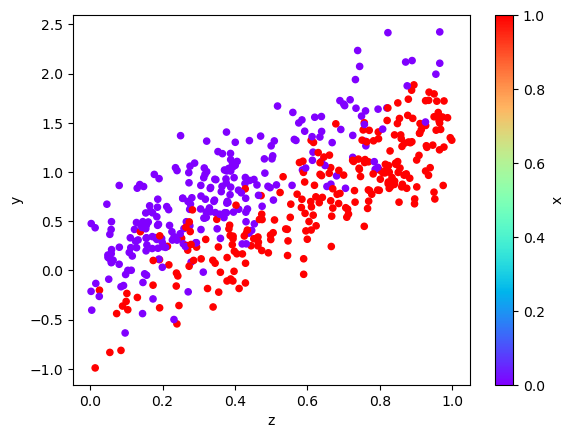

In [17]:
df1 = dg.generate_dataset_1()

df1.plot.scatter(x='z', y='y', c='x', cmap='rainbow')

In [23]:
cm = CausalModel(
    Y=df1.y.values,
    D=df1.x.values,
    X=df1.z.values,
)
cm.est_via_ols(adj=1)
print(cm.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.557      0.031    -17.746      0.000     -0.618     -0.495



/Users/kai/anaconda3/lib/python3.10/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]


In [26]:
estimate_uplift(df1)

{'estimated_effect': -0.020279099344783336,
 'standard_error': 0.09889303497739789}

## Basically,
* if we naively estimate treatment effect (x=0 vs x=1) without controling for z, we get a negative relationship: treatment decreases y (not significant)
* if we control for z, treatment effect is -0.557 and significant

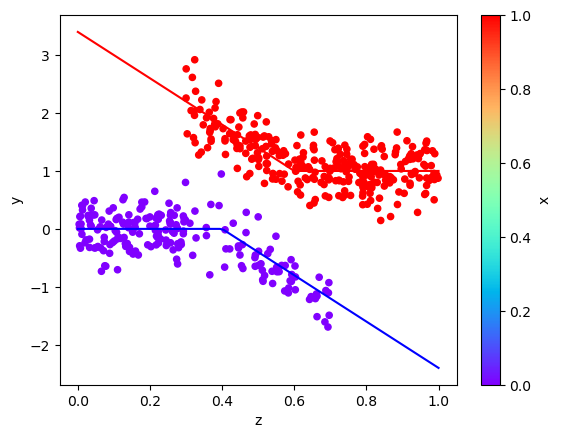

In [28]:
df3 = dg.generate_dataset_3()

df3.plot.scatter(x='z', y='y', c='x', cmap='rainbow')

# actual response curves
z = np.linspace(0,1,100)
y0 =  np.where(z >= 0.4, -4*(z - 0.4), 0)
y1 =  np.where(z < 0.6,  -4*(z - 0.6), 0) + 1
plt.plot(z,y0, "b")
plt.plot(z,y1, "r")

In [29]:
# naive cal ATE without controling for z
estimate_uplift(df3)

{'estimated_effect': 1.3917984008470388, 'standard_error': 0.08156793680400533}

In [31]:
cm = CausalModel(
    Y=df3.y.values,
    D=df3.x.values,
    X=df3.z.values,
)
cm.est_via_ols()

print(cm.estimates)


cm = CausalModel(
    Y=df3.y.values,
    D=df3.x.values,
    X=df3.z.values,
)
cm.est_via_matching()

print(cm.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.999      0.051     39.198      0.000      1.899      2.099
           ATC      1.964      0.059     33.061      0.000      1.848      2.080
           ATT      2.023      0.063     32.005      0.000      1.900      2.147


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      2.180      0.181     12.056      0.000      1.826      2.535
           ATC      2.151      0.331      6.496      0.000      1.502      2.800
           ATT      2.201      0.197     11.189      0.000      1.816      2.587



/Users/kai/anaconda3/lib/python3.10/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]


## using propensity score 

In [3]:
df1 = dg.generate_dataset_1()
df1.head()

,x,y,z
0,0,1.348346,0.683665
1,1,-1.028466,0.014292
2,0,0.470289,0.258943
3,1,0.557183,0.634718
4,0,0.662589,0.374800


<Axes: xlabel='z', ylabel='y'>

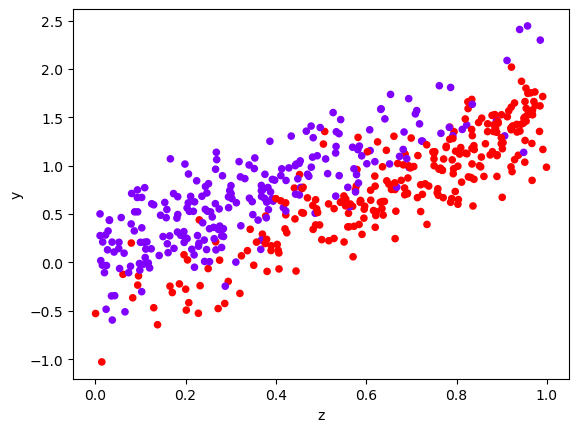

In [4]:
df1.plot.scatter(x="z", y="y", c="x", cmap="rainbow", colorbar=False)

In [8]:
estimate_uplift(df1)

{'estimated_effect': 0.11858266716617671,
 'standard_error': 0.09563100234085353}

## Propensity Score Matching
* x: covariates
* T: treatment indicatior
* y: outcome

Propensity score (ps):
$$
ps(x) = Pr(T = 1 | x) = \frac{e^{\beta x}}{1 + e^{\beta x}}
$$

Two units are comparable if propensity scores are close:
$$ ps_i \approx ps_j $$


## Propensity Score Weighting
Detailed math see notes: https://www2.stat.duke.edu/~fl35/teaching/640/Chap3.4_observational_weighting.pdf

In [13]:
cm = CausalModel(
    Y=df1.y.values,
    D=df1.x.values,
    X=df1.z.values,
)

cm.est_propensity_s()
propensity = cm.propensity['fitted'] # estimate propensity score using logistic regression: x ~ z

df = df1

# inverse of propensity score
#   how likely a point in treatment gets assigned to treatment
#   how likely a point in control gets assigned to control
df['ips'] = np.where(df.x==1, 1/propensity, 1/(1-propensity))
df['ipsw'] = df.y * df.ips 

ipse = (
    df[df.x == 1]['ipsw'].sum() - df[df.x==0]['ipsw'].sum()
) / df.shape[0]

print(ipse)



-0.5381273221119661
